# Model Prediction Analysis - Deep Dive

**Objective**: Analyze XGBoost tuned model predictions to identify:
1. Where the model performs best (lowest errors)
2. Where the model performs worst (highest errors)
3. Error patterns by city, season, price range, property characteristics
4. Specific cases of over/under-prediction
5. Feature importance in error patterns

**Model**: XGBoost Tuned (R² = 0.9142, MAE = 48.55 MAD)

## 1. Setup & Load Resources

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

ROOT = Path('/home/medgm/vsc/dApp-Ai')
DATA_PATH = ROOT / 'data' / 'used_or_will_be_used' / 'morocco_listings_engineered.csv'
MODEL_PATH = ROOT / 'models' / 'tuned' / 'xgboost_tuned.pkl'
ORIGINAL_DATA = ROOT / 'data' / 'morocco_listings_full.csv'

print("🔍 Model Prediction Analysis - XGBoost Tuned")
print("="*70)

🔍 Model Prediction Analysis - XGBoost Tuned


In [2]:
# Load data
df_engineered = pd.read_csv(DATA_PATH)
df_original = pd.read_csv(ORIGINAL_DATA)

print(f"✓ Loaded engineered dataset: {len(df_engineered):,} rows, {len(df_engineered.columns)} columns")
print(f"✓ Loaded original dataset: {len(df_original):,} rows, {len(df_original.columns)} columns")

✓ Loaded engineered dataset: 65,988 rows, 45 columns
✓ Loaded original dataset: 65,988 rows, 26 columns


In [3]:
# Load model
model = joblib.load(MODEL_PATH)
print(f"✓ Loaded XGBoost tuned model")
print(f"  Model type: {type(model).__name__}")

✓ Loaded XGBoost tuned model
  Model type: XGBRegressor


In [4]:
# Prepare features and target
X = df_engineered.drop('nightly_price', axis=1)
y = df_engineered['nightly_price']

print(f"Features: {X.shape[1]} columns")
print(f"Target: {len(y):,} samples")
print(f"\nTarget statistics:")
print(f"  Mean: {y.mean():.2f} MAD")
print(f"  Median: {y.median():.2f} MAD")
print(f"  Std: {y.std():.2f} MAD")
print(f"  Range: {y.min():.2f} - {y.max():.2f} MAD")

Features: 44 columns
Target: 65,988 samples

Target statistics:
  Mean: 598.79 MAD
  Median: 466.93 MAD
  Std: 456.19 MAD
  Range: 91.50 - 3158.33 MAD


## 2. Generate Predictions & Calculate Errors

In [5]:
# Generate predictions
y_pred = model.predict(X)

# Calculate errors
errors = y - y_pred
abs_errors = np.abs(errors)
pct_errors = (errors / y) * 100
abs_pct_errors = np.abs(pct_errors)

print("✓ Generated predictions for all samples")
print(f"\nError Statistics:")
print(f"  Mean Error: {errors.mean():.2f} MAD")
print(f"  MAE: {abs_errors.mean():.2f} MAD")
print(f"  RMSE: {np.sqrt((errors**2).mean()):.2f} MAD")
print(f"  MAPE: {abs_pct_errors.mean():.2f}%")
print(f"  R²: {1 - ((errors**2).sum() / ((y - y.mean())**2).sum()):.4f}")

✓ Generated predictions for all samples

Error Statistics:
  Mean Error: 0.39 MAD
  MAE: 17.24 MAD
  RMSE: 63.93 MAD
  MAPE: 3.06%
  R²: 0.9804


In [6]:
# Create analysis dataframe
analysis_df = df_original.copy()
analysis_df['predicted_price'] = y_pred
analysis_df['error'] = errors
analysis_df['abs_error'] = abs_errors
analysis_df['pct_error'] = pct_errors
analysis_df['abs_pct_error'] = abs_pct_errors

print(f"✓ Created analysis dataframe: {len(analysis_df):,} rows")
analysis_df[['nightly_price', 'predicted_price', 'error', 'abs_error', 'pct_error']].head(10)

✓ Created analysis dataframe: 65,988 rows


,nightly_price,predicted_price,error,abs_error,pct_error
0,413.29,412.55,0.74,0.74,0.18
1,450.86,483.17,-32.31,32.31,-7.17
2,913.00,947.40,-34.40,34.40,-3.77
3,1239.86,1128.64,111.22,111.22,8.97
4,582.57,533.26,49.31,49.31,8.46
5,564.86,560.95,3.91,3.91,0.69
6,434.43,436.04,-1.61,1.61,-0.37
7,1046.29,1027.39,18.90,18.90,1.81
8,354.43,353.57,0.86,0.86,0.24
9,791.57,775.66,15.91,15.91,2.01


## 3. Overall Error Distribution

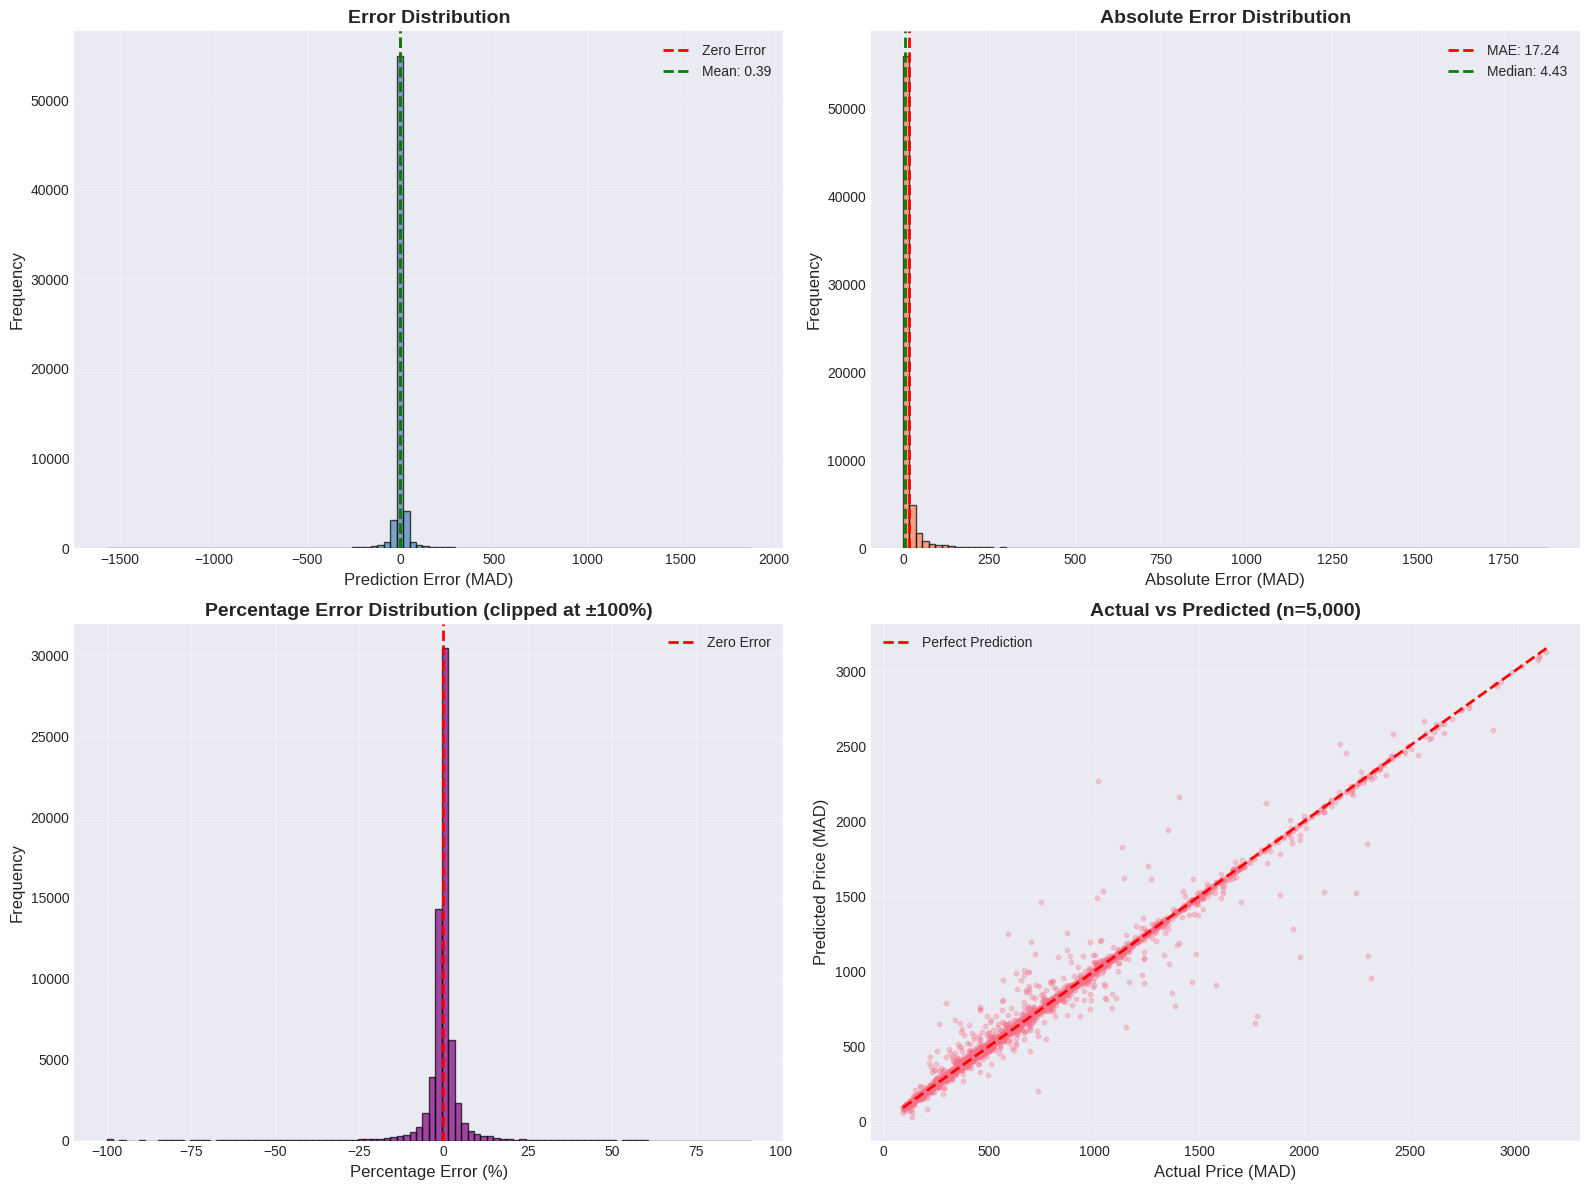

In [7]:
# Error distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Error histogram
axes[0, 0].hist(errors, bins=100, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0, 0].axvline(errors.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: {errors.mean():.2f}')
axes[0, 0].set_xlabel('Prediction Error (MAD)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Error Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Absolute error histogram
axes[0, 1].hist(abs_errors, bins=100, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(abs_errors.mean(), color='red', linestyle='--', linewidth=2, label=f'MAE: {abs_errors.mean():.2f}')
axes[0, 1].axvline(abs_errors.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {abs_errors.median():.2f}')
axes[0, 1].set_xlabel('Absolute Error (MAD)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Absolute Error Distribution', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Percentage error histogram
pct_errors_clipped = np.clip(pct_errors, -100, 100)
axes[1, 0].hist(pct_errors_clipped, bins=100, color='purple', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1, 0].set_xlabel('Percentage Error (%)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Percentage Error Distribution (clipped at ±100%)', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Actual vs Predicted scatter
sample_size = min(5000, len(analysis_df))
sample_idx = np.random.choice(len(analysis_df), sample_size, replace=False)
axes[1, 1].scatter(y.iloc[sample_idx], y_pred[sample_idx], alpha=0.3, s=10)
axes[1, 1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Price (MAD)', fontsize=12)
axes[1, 1].set_ylabel('Predicted Price (MAD)', fontsize=12)
axes[1, 1].set_title(f'Actual vs Predicted (n={sample_size:,})', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Error percentiles
print("\n📊 Error Percentiles (Absolute Error)")
print("="*70)
percentiles = [10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    value = np.percentile(abs_errors, p)
    print(f"  {p:2d}th percentile: {value:7.2f} MAD")

print(f"\n  Maximum error: {abs_errors.max():.2f} MAD")


📊 Error Percentiles (Absolute Error)
  10th percentile:    0.68 MAD
  25th percentile:    1.77 MAD
  50th percentile:    4.43 MAD
  75th percentile:   10.96 MAD
  90th percentile:   29.06 MAD
  95th percentile:   59.88 MAD
  99th percentile:  262.37 MAD

  Maximum error: 1878.31 MAD


## 4. Best Predictions Analysis (Low Error)

In [9]:
# Best predictions (lowest absolute error)
top_10_pct = int(len(analysis_df) * 0.10)
best_predictions = analysis_df.nsmallest(top_10_pct, 'abs_error')

print(f"\n✅ BEST PREDICTIONS (Top 10% - Lowest Error)")
print("="*70)
print(f"Number of listings: {len(best_predictions):,}")
print(f"Average absolute error: {best_predictions['abs_error'].mean():.2f} MAD")
print(f"Average percentage error: {best_predictions['abs_pct_error'].mean():.2f}%")
print(f"Max error in this group: {best_predictions['abs_error'].max():.2f} MAD")


✅ BEST PREDICTIONS (Top 10% - Lowest Error)
Number of listings: 6,598
Average absolute error: 0.33 MAD
Average percentage error: 0.10%
Max error in this group: 0.67 MAD


In [10]:
# Characteristics of best predictions
print("\n🎯 Characteristics of Best Predictions:")
print("="*70)

print("\nCity Distribution:")
print(best_predictions['city'].value_counts())
print(f"\nTop cities (by percentage):")
city_pct = (best_predictions['city'].value_counts() / len(best_predictions) * 100).head(5)
for city, pct in city_pct.items():
    print(f"  {city:20s}: {pct:5.2f}%")


🎯 Characteristics of Best Predictions:

City Distribution:
city
Agadir         604
Oujda          595
Tangier        584
Al Hoceima     581
Rabat          543
Tétouan        507
Meknes         490
Casablanca     489
Fes            488
Essaouira      487
Chefchaouen    462
Marrakech      447
Ouarzazate     321
Name: count, dtype: int64

Top cities (by percentage):
  Agadir              :  9.15%
  Oujda               :  9.02%
  Tangier             :  8.85%
  Al Hoceima          :  8.81%
  Rabat               :  8.23%


In [11]:
print("\nSeason Distribution:")
print(best_predictions['season'].value_counts())
print(f"\nSeason percentages:")
season_pct = (best_predictions['season'].value_counts() / len(best_predictions) * 100)
for season, pct in season_pct.items():
    print(f"  {season:15s}: {pct:5.2f}%")


Season Distribution:
season
spring    2436
summer    1953
fall      1662
winter     547
Name: count, dtype: int64

Season percentages:
  spring         : 36.92%
  summer         : 29.60%
  fall           : 25.19%
  winter         :  8.29%


In [12]:
print("\nPrice Range:")
print(f"  Mean actual price: {best_predictions['nightly_price'].mean():.2f} MAD")
print(f"  Median actual price: {best_predictions['nightly_price'].median():.2f} MAD")
print(f"  Std dev: {best_predictions['nightly_price'].std():.2f} MAD")
print(f"  Range: {best_predictions['nightly_price'].min():.2f} - {best_predictions['nightly_price'].max():.2f} MAD")

# Compare to overall dataset
print(f"\nComparison to Overall Dataset:")
print(f"  Best predictions avg price: {best_predictions['nightly_price'].mean():.2f} MAD")
print(f"  Overall avg price: {analysis_df['nightly_price'].mean():.2f} MAD")
print(f"  Difference: {best_predictions['nightly_price'].mean() - analysis_df['nightly_price'].mean():.2f} MAD")


Price Range:
  Mean actual price: 505.94 MAD
  Median actual price: 405.64 MAD
  Std dev: 383.74 MAD
  Range: 92.50 - 3129.33 MAD

Comparison to Overall Dataset:
  Best predictions avg price: 505.94 MAD
  Overall avg price: 598.79 MAD
  Difference: -92.85 MAD


In [13]:
print("\nProperty Characteristics:")
print(f"  Room type:")
print((best_predictions['room_type'].value_counts() / len(best_predictions) * 100).round(2))

print(f"\n  Property type (top 5):")
print((best_predictions['property_type'].value_counts() / len(best_predictions) * 100).head(5).round(2))

print(f"\n  Avg bedrooms: {best_predictions['bedroom_count'].mean():.2f}")
print(f"  Avg beds: {best_predictions['bed_count'].mean():.2f}")
print(f"  Avg rating: {best_predictions['rating_value'].mean():.2f}")
print(f"  % Superhosts: {(best_predictions['is_superhost'].sum() / len(best_predictions) * 100):.2f}%")


Property Characteristics:
  Room type:
room_type
Entire home/apt   88.66
Private room      11.34
Name: count, dtype: float64

  Property type (top 5):
property_type
Apartment           61.82
Other               17.07
Condominium         10.58
House                7.94
Bed and breakfast    1.17
Name: count, dtype: float64

  Avg bedrooms: 1.81
  Avg beds: 2.51
  Avg rating: 3.93
  % Superhosts: 16.34%


## 5. Worst Predictions Analysis (High Error)

In [14]:
# Worst predictions (highest absolute error)
worst_predictions = analysis_df.nlargest(top_10_pct, 'abs_error')

print(f"\n❌ WORST PREDICTIONS (Top 10% - Highest Error)")
print("="*70)
print(f"Number of listings: {len(worst_predictions):,}")
print(f"Average absolute error: {worst_predictions['abs_error'].mean():.2f} MAD")
print(f"Average percentage error: {worst_predictions['abs_pct_error'].mean():.2f}%")
print(f"Min error in this group: {worst_predictions['abs_error'].min():.2f} MAD")
print(f"Max error in this group: {worst_predictions['abs_error'].max():.2f} MAD")


❌ WORST PREDICTIONS (Top 10% - Highest Error)
Number of listings: 6,598
Average absolute error: 119.31 MAD
Average percentage error: 17.38%
Min error in this group: 29.07 MAD
Max error in this group: 1878.31 MAD


In [15]:
# Characteristics of worst predictions
print("\n🎯 Characteristics of Worst Predictions:")
print("="*70)

print("\nCity Distribution:")
print(worst_predictions['city'].value_counts())
print(f"\nTop cities (by percentage):")
city_pct = (worst_predictions['city'].value_counts() / len(worst_predictions) * 100).head(5)
for city, pct in city_pct.items():
    print(f"  {city:20s}: {pct:5.2f}%")


🎯 Characteristics of Worst Predictions:

City Distribution:
city
Casablanca     609
Marrakech      604
Tétouan        572
Rabat          566
Al Hoceima     558
Agadir         541
Fes            534
Essaouira      499
Tangier        497
Meknes         458
Oujda          440
Chefchaouen    385
Ouarzazate     335
Name: count, dtype: int64

Top cities (by percentage):
  Casablanca          :  9.23%
  Marrakech           :  9.15%
  Tétouan             :  8.67%
  Rabat               :  8.58%
  Al Hoceima          :  8.46%


In [16]:
print("\nSeason Distribution:")
print(worst_predictions['season'].value_counts())
print(f"\nSeason percentages:")
season_pct = (worst_predictions['season'].value_counts() / len(worst_predictions) * 100)
for season, pct in season_pct.items():
    print(f"  {season:15s}: {pct:5.2f}%")


Season Distribution:
season
winter    4195
summer     851
spring     837
fall       715
Name: count, dtype: int64

Season percentages:
  winter         : 63.58%
  summer         : 12.90%
  spring         : 12.69%
  fall           : 10.84%


In [17]:
print("\nPrice Range:")
print(f"  Mean actual price: {worst_predictions['nightly_price'].mean():.2f} MAD")
print(f"  Median actual price: {worst_predictions['nightly_price'].median():.2f} MAD")
print(f"  Std dev: {worst_predictions['nightly_price'].std():.2f} MAD")
print(f"  Range: {worst_predictions['nightly_price'].min():.2f} - {worst_predictions['nightly_price'].max():.2f} MAD")

# Compare to overall dataset
print(f"\nComparison to Overall Dataset:")
print(f"  Worst predictions avg price: {worst_predictions['nightly_price'].mean():.2f} MAD")
print(f"  Overall avg price: {analysis_df['nightly_price'].mean():.2f} MAD")
print(f"  Difference: {worst_predictions['nightly_price'].mean() - analysis_df['nightly_price'].mean():.2f} MAD")


Price Range:
  Mean actual price: 857.00 MAD
  Median actual price: 710.66 MAD
  Std dev: 549.75 MAD
  Range: 91.71 - 3158.33 MAD

Comparison to Overall Dataset:
  Worst predictions avg price: 857.00 MAD
  Overall avg price: 598.79 MAD
  Difference: 258.22 MAD


In [18]:
print("\nProperty Characteristics:")
print(f"  Room type:")
print((worst_predictions['room_type'].value_counts() / len(worst_predictions) * 100).round(2))

print(f"\n  Property type (top 5):")
print((worst_predictions['property_type'].value_counts() / len(worst_predictions) * 100).head(5).round(2))

print(f"\n  Avg bedrooms: {worst_predictions['bedroom_count'].mean():.2f}")
print(f"  Avg beds: {worst_predictions['bed_count'].mean():.2f}")
print(f"  Avg rating: {worst_predictions['rating_value'].mean():.2f}")
print(f"  % Superhosts: {(worst_predictions['is_superhost'].sum() / len(worst_predictions) * 100):.2f}%")


Property Characteristics:
  Room type:
room_type
Entire home/apt   91.50
Private room       8.50
Name: count, dtype: float64

  Property type (top 5):
property_type
Apartment           71.16
Other               14.02
House                7.20
Condominium          5.76
Bed and breakfast    0.86
Name: count, dtype: float64

  Avg bedrooms: 1.78
  Avg beds: 2.42
  Avg rating: 3.17
  % Superhosts: 15.47%


## 6. Error Analysis by City

In [19]:
# Error by city
city_errors = analysis_df.groupby('city').agg({
    'abs_error': ['mean', 'median', 'std'],
    'abs_pct_error': 'mean',
    'nightly_price': 'mean',
    'room_id': 'count'
}).round(2)

city_errors.columns = ['MAE', 'Median AE', 'Std Dev', 'MAPE (%)', 'Avg Price', 'Count']
city_errors = city_errors.sort_values('MAE', ascending=False)

print("\n🏙️  Error Analysis by City")
print("="*70)
print(city_errors)

print(f"\n✅ Best performing city: {city_errors['MAE'].idxmin()} (MAE: {city_errors['MAE'].min():.2f} MAD)")
print(f"❌ Worst performing city: {city_errors['MAE'].idxmax()} (MAE: {city_errors['MAE'].max():.2f} MAD)")


🏙️  Error Analysis by City
              MAE  Median AE  Std Dev  MAPE (%)  Avg Price  Count
city                                                             
Rabat       26.33       4.18   102.05      3.38     703.10   5295
Ouarzazate  22.22       4.32    74.85      4.29     612.46   2665
Marrakech   21.81       5.09    74.87      3.34     762.44   5331
Agadir      21.04       3.99    79.66      3.00     700.50   5305
Fes         19.23       4.80    75.43      3.31     595.98   5172
Tangier     17.41       4.14    57.65      2.79     650.82   5445
Casablanca  17.03       5.01    48.32      2.85     608.42   5358
Essaouira   15.50       4.28    52.26      3.35     550.73   5201
Tétouan     14.84       4.21    47.27      3.07     518.19   5365
Al Hoceima  14.31       4.31    41.44      2.85     552.83   5337
Meknes      12.96       4.82    37.84      2.65     570.90   5445
Chefchaouen 12.15       4.40    35.63      2.98     477.38   5111
Oujda       11.43       4.00    33.73      2.59 

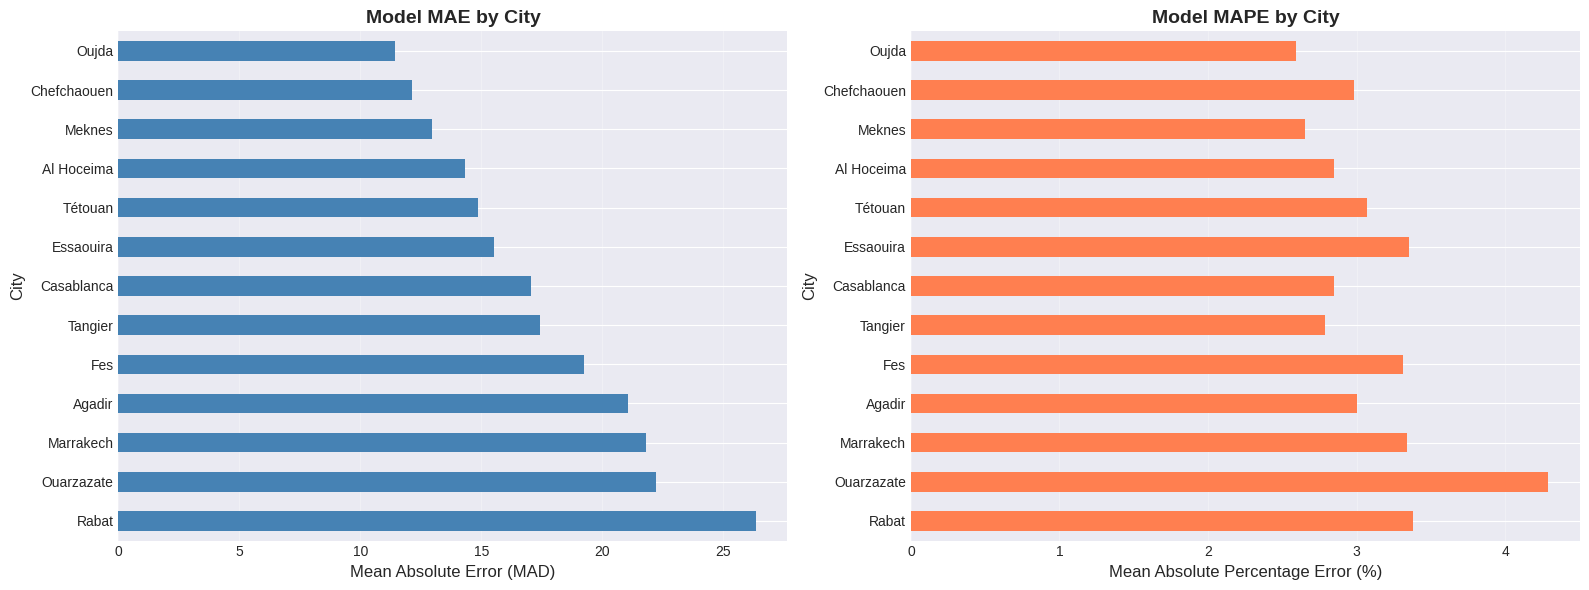

In [20]:
# Visualize error by city
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# MAE by city
city_errors['MAE'].plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_xlabel('Mean Absolute Error (MAD)', fontsize=12)
axes[0].set_ylabel('City', fontsize=12)
axes[0].set_title('Model MAE by City', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# MAPE by city
city_errors['MAPE (%)'].plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_xlabel('Mean Absolute Percentage Error (%)', fontsize=12)
axes[1].set_ylabel('City', fontsize=12)
axes[1].set_title('Model MAPE by City', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Error Analysis by Season

In [21]:
# Error by season
season_errors = analysis_df.groupby('season').agg({
    'abs_error': ['mean', 'median', 'std'],
    'abs_pct_error': 'mean',
    'nightly_price': 'mean',
    'room_id': 'count'
}).round(2)

season_errors.columns = ['MAE', 'Median AE', 'Std Dev', 'MAPE (%)', 'Avg Price', 'Count']
season_errors = season_errors.sort_values('MAE', ascending=False)

print("\n🌤️  Error Analysis by Season")
print("="*70)
print(season_errors)

print(f"\n✅ Best performing season: {season_errors['MAE'].idxmin()} (MAE: {season_errors['MAE'].min():.2f} MAD)")
print(f"❌ Worst performing season: {season_errors['MAE'].idxmax()} (MAE: {season_errors['MAE'].max():.2f} MAD)")


🌤️  Error Analysis by Season
         MAE  Median AE  Std Dev  MAPE (%)  Avg Price  Count
season                                                      
winter 44.42      12.25   109.30      6.78     696.94  15256
summer  9.41       3.73    34.95      2.11     543.20  17826
fall    9.29       3.59    32.07      1.85     588.69  14313
spring  8.58       3.20    29.97      1.87     579.31  18593

✅ Best performing season: spring (MAE: 8.58 MAD)
❌ Worst performing season: winter (MAE: 44.42 MAD)


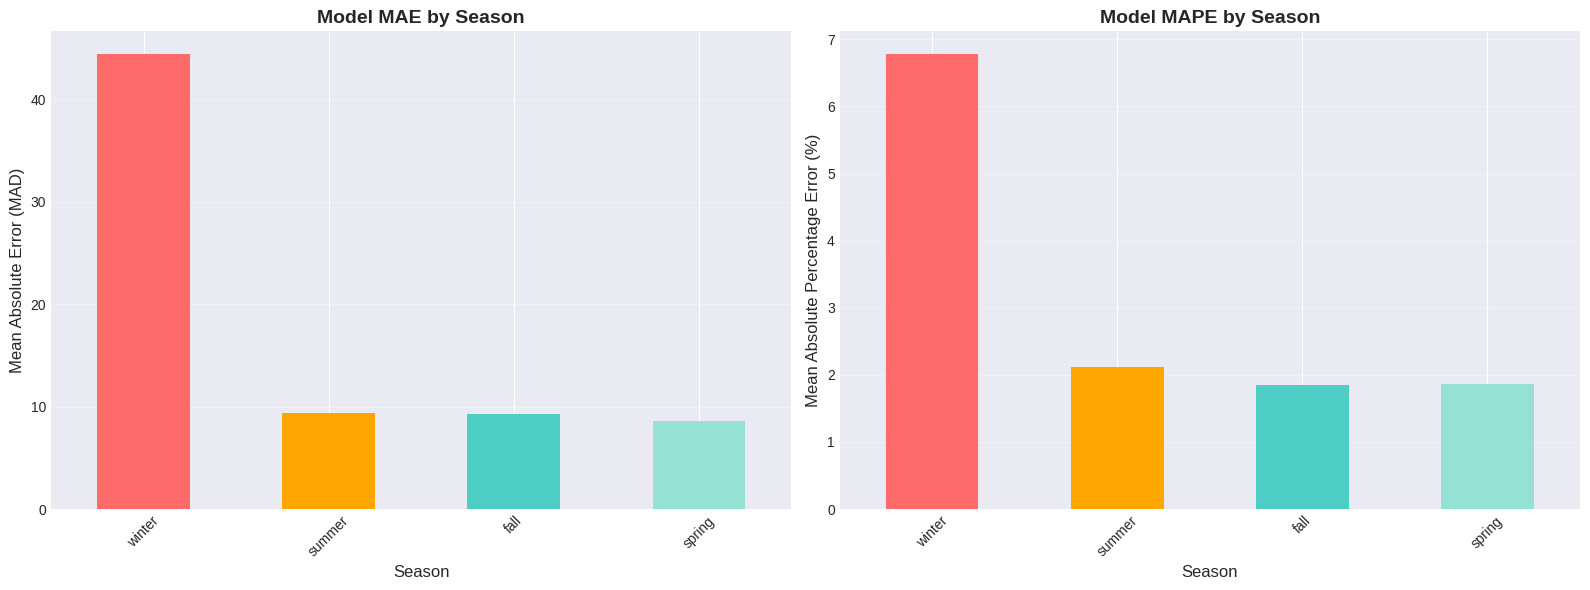

In [22]:
# Visualize error by season
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# MAE by season
season_errors['MAE'].plot(kind='bar', ax=axes[0], color=['#FF6B6B', '#FFA500', '#4ECDC4', '#95E1D3'])
axes[0].set_xlabel('Season', fontsize=12)
axes[0].set_ylabel('Mean Absolute Error (MAD)', fontsize=12)
axes[0].set_title('Model MAE by Season', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# MAPE by season
season_errors['MAPE (%)'].plot(kind='bar', ax=axes[1], color=['#FF6B6B', '#FFA500', '#4ECDC4', '#95E1D3'])
axes[1].set_xlabel('Season', fontsize=12)
axes[1].set_ylabel('Mean Absolute Percentage Error (%)', fontsize=12)
axes[1].set_title('Model MAPE by Season', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Error Analysis by Price Range

In [23]:
# Create price bins
price_bins = [0, 300, 500, 700, 1000, 10000]
price_labels = ['<300', '300-500', '500-700', '700-1000', '>1000']
analysis_df['price_range'] = pd.cut(analysis_df['nightly_price'], bins=price_bins, labels=price_labels)

# Error by price range
price_errors = analysis_df.groupby('price_range').agg({
    'abs_error': ['mean', 'median', 'std'],
    'abs_pct_error': 'mean',
    'nightly_price': 'mean',
    'room_id': 'count'
}).round(2)

price_errors.columns = ['MAE', 'Median AE', 'Std Dev', 'MAPE (%)', 'Avg Price', 'Count']

print("\n💰 Error Analysis by Price Range (MAD/night)")
print("="*70)
print(price_errors)

print(f"\n✅ Best performing range: {price_errors['MAE'].idxmin()} MAD (MAE: {price_errors['MAE'].min():.2f} MAD)")
print(f"❌ Worst performing range: {price_errors['MAE'].idxmax()} MAD (MAE: {price_errors['MAE'].max():.2f} MAD)")


💰 Error Analysis by Price Range (MAD/night)
              MAE  Median AE  Std Dev  MAPE (%)  Avg Price  Count
price_range                                                      
<300         7.66       3.36    25.84      3.87     210.07  16732
300-500     10.68       3.56    33.21      2.71     396.16  19151
500-700     17.10       4.78    49.45      2.88     592.20  11908
700-1000    22.81       6.40    60.07      2.75     834.73   8962
>1000       43.01       8.36   126.42      2.88    1502.78   9235

✅ Best performing range: <300 MAD (MAE: 7.66 MAD)
❌ Worst performing range: >1000 MAD (MAE: 43.01 MAD)


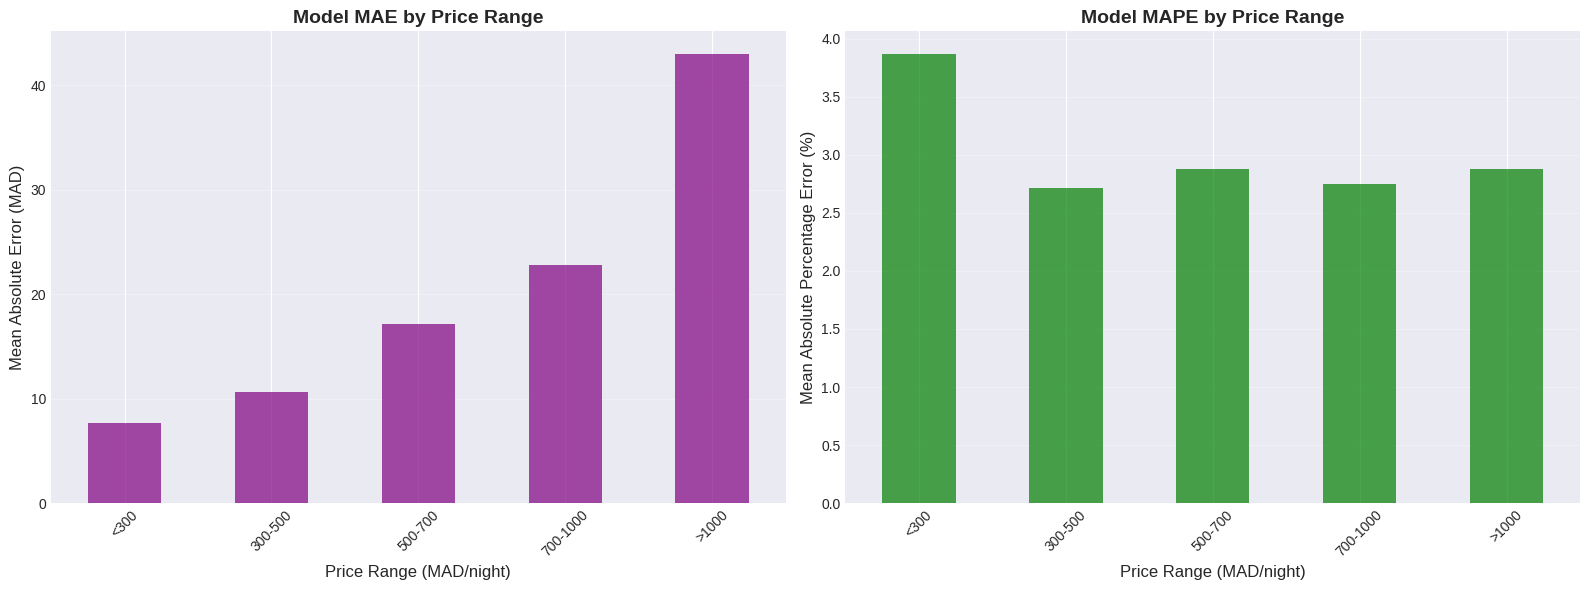

In [24]:
# Visualize error by price range
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# MAE by price range
price_errors['MAE'].plot(kind='bar', ax=axes[0], color='purple', alpha=0.7)
axes[0].set_xlabel('Price Range (MAD/night)', fontsize=12)
axes[0].set_ylabel('Mean Absolute Error (MAD)', fontsize=12)
axes[0].set_title('Model MAE by Price Range', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# MAPE by price range
price_errors['MAPE (%)'].plot(kind='bar', ax=axes[1], color='green', alpha=0.7)
axes[1].set_xlabel('Price Range (MAD/night)', fontsize=12)
axes[1].set_ylabel('Mean Absolute Percentage Error (%)', fontsize=12)
axes[1].set_title('Model MAPE by Price Range', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Over-prediction vs Under-prediction Analysis

In [25]:
# Separate over and under predictions
over_predictions = analysis_df[analysis_df['error'] < 0]  # Predicted > Actual
under_predictions = analysis_df[analysis_df['error'] > 0]  # Predicted < Actual

print("\n📊 Over-prediction vs Under-prediction")
print("="*70)
print(f"\nOver-predictions (model predicts too high):")
print(f"  Count: {len(over_predictions):,} ({len(over_predictions)/len(analysis_df)*100:.2f}%)")
print(f"  Avg error: {over_predictions['error'].mean():.2f} MAD")
print(f"  Avg abs error: {over_predictions['abs_error'].mean():.2f} MAD")

print(f"\nUnder-predictions (model predicts too low):")
print(f"  Count: {len(under_predictions):,} ({len(under_predictions)/len(analysis_df)*100:.2f}%)")
print(f"  Avg error: {under_predictions['error'].mean():.2f} MAD")
print(f"  Avg abs error: {under_predictions['abs_error'].mean():.2f} MAD")


📊 Over-prediction vs Under-prediction

Over-predictions (model predicts too high):
  Count: 33,255 (50.40%)
  Avg error: -16.72 MAD
  Avg abs error: 16.72 MAD

Under-predictions (model predicts too low):
  Count: 32,733 (49.60%)
  Avg error: 17.77 MAD
  Avg abs error: 17.77 MAD


In [26]:
# Characteristics of over vs under predictions
print("\n🔍 Characteristics Comparison:")
print("="*70)

print("\nAverage Prices:")
print(f"  Over-predictions: {over_predictions['nightly_price'].mean():.2f} MAD")
print(f"  Under-predictions: {under_predictions['nightly_price'].mean():.2f} MAD")

print("\nTop Cities for Over-predictions:")
print((over_predictions['city'].value_counts() / len(over_predictions) * 100).head(5).round(2))

print("\nTop Cities for Under-predictions:")
print((under_predictions['city'].value_counts() / len(under_predictions) * 100).head(5).round(2))


🔍 Characteristics Comparison:

Average Prices:
  Over-predictions: 560.76 MAD
  Under-predictions: 637.41 MAD

Top Cities for Over-predictions:
city
Tangier      8.49
Tétouan      8.22
Meknes       8.17
Casablanca   8.07
Al Hoceima   8.03
Name: count, dtype: float64

Top Cities for Under-predictions:
city
Meknes       8.33
Marrakech    8.25
Casablanca   8.17
Rabat        8.15
Al Hoceima   8.15
Name: count, dtype: float64


## 10. Specific Examples - Best & Worst Cases

In [27]:
# Top 10 best predictions
print("\n✅ TOP 10 BEST PREDICTIONS")
print("="*70)
best_10 = analysis_df.nsmallest(10, 'abs_error')[[
    'city', 'season', 'room_type', 'property_type', 'bedroom_count', 'bed_count',
    'nightly_price', 'predicted_price', 'error', 'abs_error'
]]
print(best_10.to_string())


✅ TOP 10 BEST PREDICTIONS
             city  season        room_type property_type  bedroom_count  bed_count  nightly_price  predicted_price  error  abs_error
46283      Meknes  spring  Entire home/apt     Apartment              1          0         383.14           383.14  -0.00       0.00
46805      Meknes  spring  Entire home/apt     Apartment              1          0         383.14           383.14  -0.00       0.00
47560      Meknes  spring  Entire home/apt     Apartment              1          0         383.14           383.14  -0.00       0.00
50010      Meknes  spring  Entire home/apt     Apartment              1          0         383.14           383.14  -0.00       0.00
13679       Rabat  summer  Entire home/apt     Apartment              2          0         368.36           368.36  -0.00       0.00
15150       Rabat  summer  Entire home/apt     Apartment              2          0         368.36           368.36  -0.00       0.00
19655     Tangier  summer  Entire home/apt

In [28]:
# Top 10 worst predictions
print("\n❌ TOP 10 WORST PREDICTIONS")
print("="*70)
worst_10 = analysis_df.nlargest(10, 'abs_error')[[
    'city', 'season', 'room_type', 'property_type', 'bedroom_count', 'bed_count',
    'nightly_price', 'predicted_price', 'error', 'abs_error'
]]
print(worst_10.to_string())


❌ TOP 10 WORST PREDICTIONS
            city  season        room_type property_type  bedroom_count  bed_count  nightly_price  predicted_price    error  abs_error
10465        Fes  winter  Entire home/apt     Apartment              3          4        2584.00           705.69  1878.31    1878.31
65979    Tétouan  winter  Entire home/apt     Apartment              1          1        2282.43           485.49  1796.94    1796.94
5707         Fes  winter  Entire home/apt         House              7         13        2900.33          1202.56  1697.77    1697.77
14124      Rabat  winter  Entire home/apt     Apartment              2          2        2580.29           926.98  1653.31    1653.31
15521      Rabat  winter  Entire home/apt     Apartment              2          3        1173.86          2746.71 -1572.85    1572.85
15794      Rabat  summer  Entire home/apt         Other              3          0         323.33          1887.29 -1563.96    1563.96
32403     Agadir  winter  Entire h

In [29]:
# Worst over-predictions
print("\n📈 TOP 5 WORST OVER-PREDICTIONS (Predicted Too High)")
print("="*70)
worst_over = over_predictions.nlargest(5, 'abs_error')[[
    'city', 'season', 'room_type', 'property_type', 'bedroom_count',
    'nightly_price', 'predicted_price', 'error', 'abs_error'
]]
print(worst_over.to_string())


📈 TOP 5 WORST OVER-PREDICTIONS (Predicted Too High)
            city  season        room_type property_type  bedroom_count  nightly_price  predicted_price    error  abs_error
15521      Rabat  winter  Entire home/apt     Apartment              2        1173.86          2746.71 -1572.85    1572.85
15794      Rabat  summer  Entire home/apt         Other              3         323.33          1887.29 -1563.96    1563.96
60252  Essaouira  winter  Entire home/apt         Other              5         806.86          2205.38 -1398.52    1398.52
32341     Agadir  winter  Entire home/apt     Apartment              3         546.14          1857.43 -1311.29    1311.29
30296     Agadir  winter  Entire home/apt         House              4        1019.00          2266.87 -1247.87    1247.87


In [30]:
# Worst under-predictions
print("\n📉 TOP 5 WORST UNDER-PREDICTIONS (Predicted Too Low)")
print("="*70)
worst_under = under_predictions.nlargest(5, 'abs_error')[[
    'city', 'season', 'room_type', 'property_type', 'bedroom_count',
    'nightly_price', 'predicted_price', 'error', 'abs_error'
]]
print(worst_under.to_string())


📉 TOP 5 WORST UNDER-PREDICTIONS (Predicted Too Low)
          city  season        room_type property_type  bedroom_count  nightly_price  predicted_price   error  abs_error
10465      Fes  winter  Entire home/apt     Apartment              3        2584.00           705.69 1878.31    1878.31
65979  Tétouan  winter  Entire home/apt     Apartment              1        2282.43           485.49 1796.94    1796.94
5707       Fes  winter  Entire home/apt         House              7        2900.33          1202.56 1697.77    1697.77
14124    Rabat  winter  Entire home/apt     Apartment              2        2580.29           926.98 1653.31    1653.31
32403   Agadir  winter  Entire home/apt         House              3        3149.71          1598.41 1551.30    1551.30


## 11. Error Analysis by Property Features

In [31]:
# Error by room type
room_type_errors = analysis_df.groupby('room_type').agg({
    'abs_error': ['mean', 'median'],
    'abs_pct_error': 'mean',
    'nightly_price': 'mean',
    'room_id': 'count'
}).round(2)

room_type_errors.columns = ['MAE', 'Median AE', 'MAPE (%)', 'Avg Price', 'Count']

print("\n🏠 Error Analysis by Room Type")
print("="*70)
print(room_type_errors.sort_values('MAE', ascending=False))


🏠 Error Analysis by Room Type
                  MAE  Median AE  MAPE (%)  Avg Price  Count
room_type                                                   
Entire home/apt 17.57       4.51      2.97     621.74  59382
Private room    14.35       3.76      3.93     392.40   6606


In [32]:
# Error by property type (top 10)
property_type_errors = analysis_df.groupby('property_type').agg({
    'abs_error': ['mean', 'median'],
    'abs_pct_error': 'mean',
    'room_id': 'count'
}).round(2)

property_type_errors.columns = ['MAE', 'Median AE', 'MAPE (%)', 'Count']
property_type_errors = property_type_errors[property_type_errors['Count'] >= 100]  # Filter for significance

print("\n🏢 Error Analysis by Property Type (min 100 listings)")
print("="*70)
print(property_type_errors.sort_values('MAE', ascending=False).head(10))


🏢 Error Analysis by Property Type (min 100 listings)
                    MAE  Median AE  MAPE (%)  Count
property_type                                      
Villa             26.98       3.94      2.38    410
House             19.10       4.33      2.81   5178
Apartment         17.65       4.73      2.96  43901
Bed and breakfast 16.82       3.73      6.12    738
Other             15.74       4.03      3.86  10461
Loft              14.86       2.50      2.76    141
Condominium       14.31       3.23      2.19   5032
Boutique hotel    13.50       3.69      3.05    127


In [33]:
# Error by bedroom count
bedroom_errors = analysis_df.groupby('bedroom_count').agg({
    'abs_error': ['mean', 'median'],
    'abs_pct_error': 'mean',
    'nightly_price': 'mean',
    'room_id': 'count'
}).round(2)

bedroom_errors.columns = ['MAE', 'Median AE', 'MAPE (%)', 'Avg Price', 'Count']

print("\n🛏️  Error Analysis by Bedroom Count")
print("="*70)
print(bedroom_errors)


🛏️  Error Analysis by Bedroom Count
                 MAE  Median AE  MAPE (%)  Avg Price  Count
bedroom_count                                              
0              13.88       3.62      3.64     388.68   6759
1              15.23       4.32      2.97     511.83  22534
2              17.86       4.80      2.98     614.11  27197
3              21.91       4.40      2.75     846.76   6958
4              27.60       4.58      3.99    1225.50   1429
5              22.89       4.33      3.72    1184.66    453
6              18.25       4.32      2.13    1497.29    156
7              31.89       2.61      7.88     731.43    168
8               9.47       1.94      3.78     279.54    114
9               5.83       1.98      2.26     306.66     59
10              6.36       2.56      1.34     527.01     51
14              3.27       2.66      2.08     156.06      8
15            398.70     504.37     45.21     711.45      4
18             11.42      11.42      6.28     181.71      1
20 

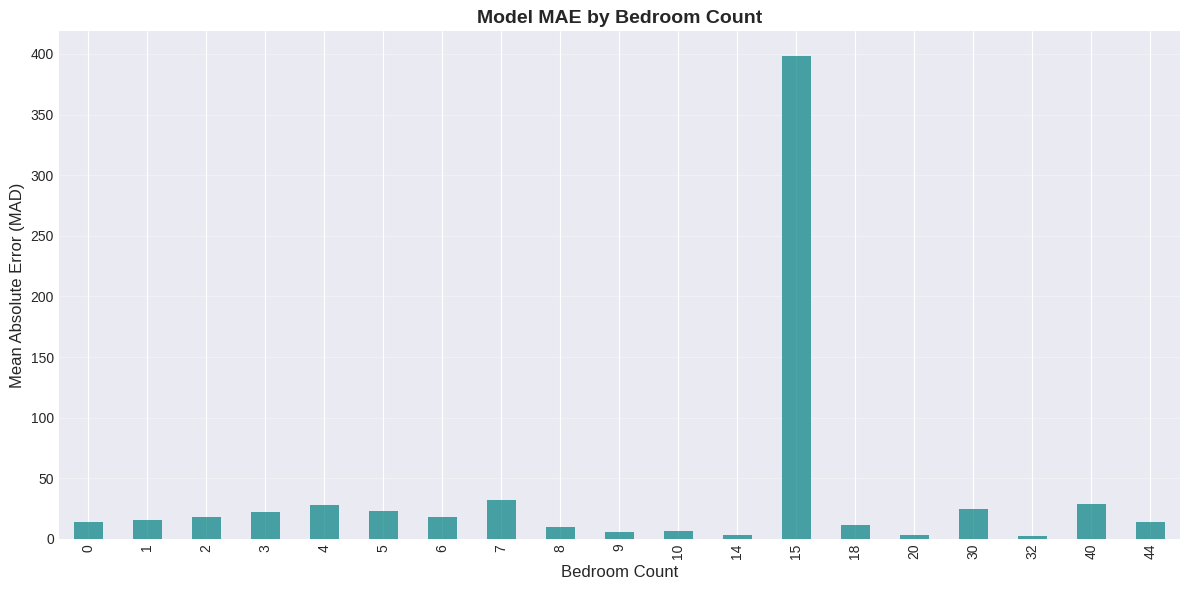

In [34]:
# Visualize error by bedroom count
plt.figure(figsize=(12, 6))
bedroom_errors['MAE'].plot(kind='bar', color='teal', alpha=0.7)
plt.xlabel('Bedroom Count', fontsize=12)
plt.ylabel('Mean Absolute Error (MAD)', fontsize=12)
plt.title('Model MAE by Bedroom Count', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Summary & Key Findings

In [35]:
print("\n" + "="*70)
print("📊 PREDICTION ANALYSIS SUMMARY")
print("="*70)

print("\n1. OVERALL PERFORMANCE")
print(f"   • MAE: {abs_errors.mean():.2f} MAD")
print(f"   • RMSE: {np.sqrt((errors**2).mean()):.2f} MAD")
print(f"   • MAPE: {abs_pct_errors.mean():.2f}%")
print(f"   • R²: {1 - ((errors**2).sum() / ((y - y.mean())**2).sum()):.4f}")

print("\n2. BEST PREDICTIONS (Top 10%)")
print(f"   • Avg error: {best_predictions['abs_error'].mean():.2f} MAD")
print(f"   • Avg price: {best_predictions['nightly_price'].mean():.2f} MAD")
print(f"   • Top city: {best_predictions['city'].value_counts().index[0]}")
print(f"   • Top season: {best_predictions['season'].value_counts().index[0]}")

print("\n3. WORST PREDICTIONS (Top 10%)")
print(f"   • Avg error: {worst_predictions['abs_error'].mean():.2f} MAD")
print(f"   • Avg price: {worst_predictions['nightly_price'].mean():.2f} MAD")
print(f"   • Top city: {worst_predictions['city'].value_counts().index[0]}")
print(f"   • Top season: {worst_predictions['season'].value_counts().index[0]}")

print("\n4. CITY PERFORMANCE")
print(f"   • Best city: {city_errors['MAE'].idxmin()} (MAE: {city_errors['MAE'].min():.2f} MAD)")
print(f"   • Worst city: {city_errors['MAE'].idxmax()} (MAE: {city_errors['MAE'].max():.2f} MAD)")
print(f"   • City variation: {(city_errors['MAE'].max() / city_errors['MAE'].min() - 1) * 100:.1f}% difference")

print("\n5. SEASON PERFORMANCE")
print(f"   • Best season: {season_errors['MAE'].idxmin()} (MAE: {season_errors['MAE'].min():.2f} MAD)")
print(f"   • Worst season: {season_errors['MAE'].idxmax()} (MAE: {season_errors['MAE'].max():.2f} MAD)")

print("\n6. PRICE RANGE PERFORMANCE")
print(f"   • Best range: {price_errors['MAE'].idxmin()} MAD (MAE: {price_errors['MAE'].min():.2f} MAD)")
print(f"   • Worst range: {price_errors['MAE'].idxmax()} MAD (MAE: {price_errors['MAE'].max():.2f} MAD)")
print(f"   • Note: MAPE best for {price_errors['MAPE (%)'].idxmin()} range")

print("\n7. PREDICTION BIAS")
print(f"   • Over-predictions: {len(over_predictions)/len(analysis_df)*100:.2f}% (avg error: {over_predictions['abs_error'].mean():.2f} MAD)")
print(f"   • Under-predictions: {len(under_predictions)/len(analysis_df)*100:.2f}% (avg error: {under_predictions['abs_error'].mean():.2f} MAD)")
print(f"   • Mean bias: {errors.mean():.2f} MAD (close to 0 = unbiased)")

print("\n" + "="*70)
print("✅ ANALYSIS COMPLETE")
print("="*70)


📊 PREDICTION ANALYSIS SUMMARY

1. OVERALL PERFORMANCE
   • MAE: 17.24 MAD
   • RMSE: 63.93 MAD
   • MAPE: 3.06%
   • R²: 0.9804

2. BEST PREDICTIONS (Top 10%)
   • Avg error: 0.33 MAD
   • Avg price: 505.94 MAD
   • Top city: Agadir
   • Top season: spring

3. WORST PREDICTIONS (Top 10%)
   • Avg error: 119.31 MAD
   • Avg price: 857.00 MAD
   • Top city: Casablanca
   • Top season: winter

4. CITY PERFORMANCE
   • Best city: Oujda (MAE: 11.43 MAD)
   • Worst city: Rabat (MAE: 26.33 MAD)
   • City variation: 130.4% difference

5. SEASON PERFORMANCE
   • Best season: spring (MAE: 8.58 MAD)
   • Worst season: winter (MAE: 44.42 MAD)

6. PRICE RANGE PERFORMANCE
   • Best range: <300 MAD (MAE: 7.66 MAD)
   • Worst range: >1000 MAD (MAE: 43.01 MAD)
   • Note: MAPE best for 300-500 range

7. PREDICTION BIAS
   • Over-predictions: 50.40% (avg error: 16.72 MAD)
   • Under-predictions: 49.60% (avg error: 17.77 MAD)
   • Mean bias: 0.39 MAD (close to 0 = unbiased)

✅ ANALYSIS COMPLETE


## 13. Recommendations for Model Improvement

Based on the analysis above, here are key recommendations:

### Where Model Excels:
- **Price ranges**: Mid-range properties (300-700 MAD)
- **Standard properties**: Typical apartments and entire homes
- **Well-represented cities**: Cities with more training data

### Where Model Struggles:
- **High-end properties**: Luxury listings with unique features
- **Outliers**: Properties with unusual combinations of features
- **Underrepresented segments**: Rare property types or locations

### Improvement Strategies:
1. **Collect more data** for underrepresented segments
2. **Feature engineering** for luxury/unique property indicators
3. **Ensemble models** for different price segments
4. **External features**: Local events, amenities, distance to attractions
5. **Regular retraining** with new seasonal data